## Time Series Modelling -  Hourly Water Consumption in the Greater Stuttgart
Landenwasserversorgung

In [68]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.imputation.mice import MICEData  # for MICE imputation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pmdarima as pmd  # for auto_arima
import h5py  # for hdf5 files
import json
import warnings
from utils.sarima_forecast import (
    train_and_forecast_sarima,
)  # for SARIMA model training and forecasting
from utils.fourier import fourier_series
import missingno as msno  # for missing data visualization
import seaborn as sns  # for correlation matrix
import gzip  # for gzip files
import shutil  # for gzip files
from prophet import Prophet

warnings.filterwarnings("ignore")

### 1.) Load Data

#### 1.1.) Read in water demand data

In [2]:
# Explore the structure of an HDF5 file
def explore_h5_structure(h5_file):
    for key in h5_file.keys():
        print(f"Group/Dataset: {key}")
        if isinstance(h5_file[key], h5py.Group):
            explore_h5_structure(h5_file[key])  # Recursively explore groups
        elif isinstance(h5_file[key], h5py.Dataset):
            print(f"Dataset shape: {h5_file[key].shape}, dtype: {h5_file[key].dtype}")

In [3]:
# Open the file
with h5py.File("../data/water_demand/system_demand.h5", "r") as system_demand:
    explore_h5_structure(system_demand)

Group/Dataset: system_demand
Group/Dataset: n_nodal_datapoints_available
Dataset shape: (247463,), dtype: float64
Group/Dataset: nodal_demand_sum
Dataset shape: (247463,), dtype: float64
Group/Dataset: time
Dataset shape: (7, 247463), dtype: int64


In [4]:
with h5py.File("../data/water_demand/system_demand.h5", "r") as system_demand:
    # Access a specific group
    group = system_demand["system_demand"]
    # Load the dataset into memory
    n_nodal_datapoints_available = group["n_nodal_datapoints_available"][:]
    nodal_demand = group["nodal_demand_sum"][:]
    system_time = group["time"][:]

In [5]:
# Build pandas df with datetime, nodal_demand_sum, n_nodal_datapoints_available
system_time_transposed = np.transpose(
    system_time
)  # transpose system time in long format
# create dataframe
df = pd.DataFrame(
    system_time_transposed,
    columns=["year", "month", "day", "hour", "minute", "second", "milisecond"],
)
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour", "minute"]])
df["nodal_demand"] = nodal_demand
df["n_nodal_datapoints_available"] = n_nodal_datapoints_available
df.set_index("datetime", inplace=True)
df_hourly = df.resample(
    "h"
).median()  # Use sum for total demand per hour.resample('h').mean() #resample to hourly mean demand in liter/s
df_hourly = df_hourly.drop(
    columns=["year", "month", "day", "hour", "minute", "second", "milisecond"]
)
df_hourly["date"] = df_hourly.index
df_hourly.head(5)

,nodal_demand,n_nodal_datapoints_available,date
datetime,,,
2016-12-30 23:00:00,3117.642772,29.0,2016-12-30 23:00:00
2016-12-31 00:00:00,2476.503474,29.0,2016-12-31 00:00:00
2016-12-31 01:00:00,2336.120475,29.0,2016-12-31 01:00:00
2016-12-31 02:00:00,1882.216795,29.0,2016-12-31 02:00:00
2016-12-31 03:00:00,1821.650324,29.0,2016-12-31 03:00:00


##### 1.1.1.) Deal with missing data


In [6]:
# Only seven missing values, impute via mean of nearest neighbors
df_hourly[df_hourly["nodal_demand"].isna()]

,nodal_demand,n_nodal_datapoints_available,date
datetime,,,
2017-03-26 02:00:00,NaN,NaN,2017-03-26 02:00:00
2018-03-25 02:00:00,NaN,NaN,2018-03-25 02:00:00
2019-03-31 02:00:00,NaN,NaN,2019-03-31 02:00:00
2020-03-29 02:00:00,NaN,NaN,2020-03-29 02:00:00
2021-03-28 02:00:00,NaN,NaN,2021-03-28 02:00:00
2022-03-27 02:00:00,NaN,NaN,2022-03-27 02:00:00
2023-03-26 02:00:00,NaN,NaN,2023-03-26 02:00:00


In [7]:
# Fill missing values with the previous value
df_hourly = df_hourly.fillna(method="ffill")

#### 1.2.) Read in weather and holiday data
Weather data from the DWD stations Stuttgart-Schnarrenberg and Stuttgart-Echterdingen

In [8]:
# Load the Raw temperature data
temperature_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Temperaturdaten_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"TT_TU": "temperature"})

temperature_echterdingen = pd.read_csv(
    "../data/weather_climate/Temperaturdaten_Echterdingen_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"TT_TU": "temperature"})

temperature = pd.merge(
    temperature_schnarrenberg,
    temperature_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [9]:
sun_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Sonnenschein_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"SD_SO": "sunshine_duration"})

sun_echterdingen = pd.read_csv(
    "../data/weather_climate/Sonnenschein_Echterdingen_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"SD_SO": "sunshine_duration"})

sunshine = pd.merge(
    sun_schnarrenberg,
    sun_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [10]:
precipitation_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Niederschlag_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"  R1": "precipitation"})

precipitation_echterdingen = pd.read_csv(
    "../data/weather_climate/Niederschlag_Echterdingen_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"  R1": "precipitation"})


precipitation = pd.merge(
    precipitation_schnarrenberg,
    precipitation_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [11]:
soil = pd.read_csv(
    "../data/weather_climate/derived_germany_soil_daily_historical_4928.csv",
    delimiter=";",
    parse_dates=["Datum"],
).rename(columns={"Datum": "date"})
soil = soil[["date", "BF10", "BF20", "BF30", "BF40", "BF50", "BF60"]]

In [12]:
# create weather data
weather = pd.merge(
    temperature, sunshine, left_index=True, right_index=True, how="outer"
).merge(
    precipitation, left_index=True, right_index=True, how="outer"
)  # Merge all hourly weather data


weather.index = pd.to_datetime(weather.index, format="%Y%m%d%H")


weather["datetime"] = pd.to_datetime(weather.index)


weather["date"] = pd.to_datetime(weather.index.date)


weather = pd.merge(weather, soil, on="date", how="left")  # merge soil data


weather = weather.set_index("datetime")  # reset index


weather.replace(-999, np.nan, inplace=True)  # Replace missing values with NaN


weather = weather[
    [
        "temperature_Schnar",
        "temperature_Echt",
        "sunshine_duration_Schnar",
        "sunshine_duration_Echt",
        "precipitation_Schnar",
        "precipitation_Echt",
        "BF10",
        "BF20",
        "BF30",
        "BF40",
        "BF50",
        "BF60",
    ]
]


weather = weather[weather.index >= "2018-01-01"]  # select data from 2018 onwards

##### 1.2.1.) Deal with missing data
Probably due to maintaince issues a "Missing at Random" (MAR) mechansim is given for the weather data, for both weather stations. Multiple Imputation (MI) is considered to impute missing data.

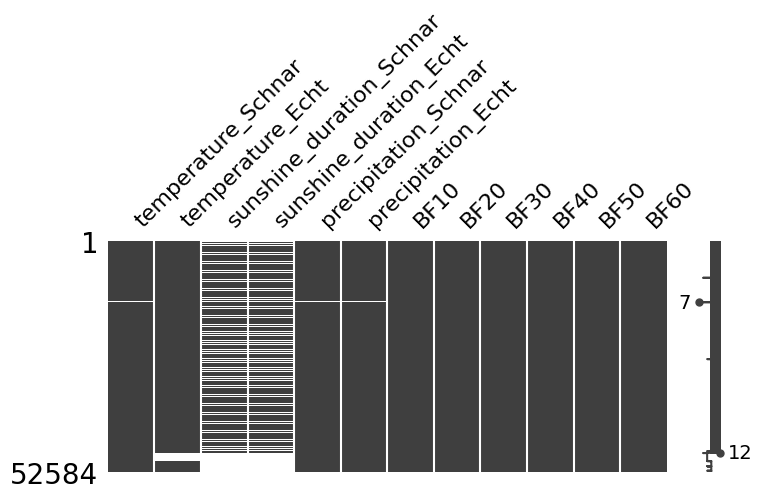

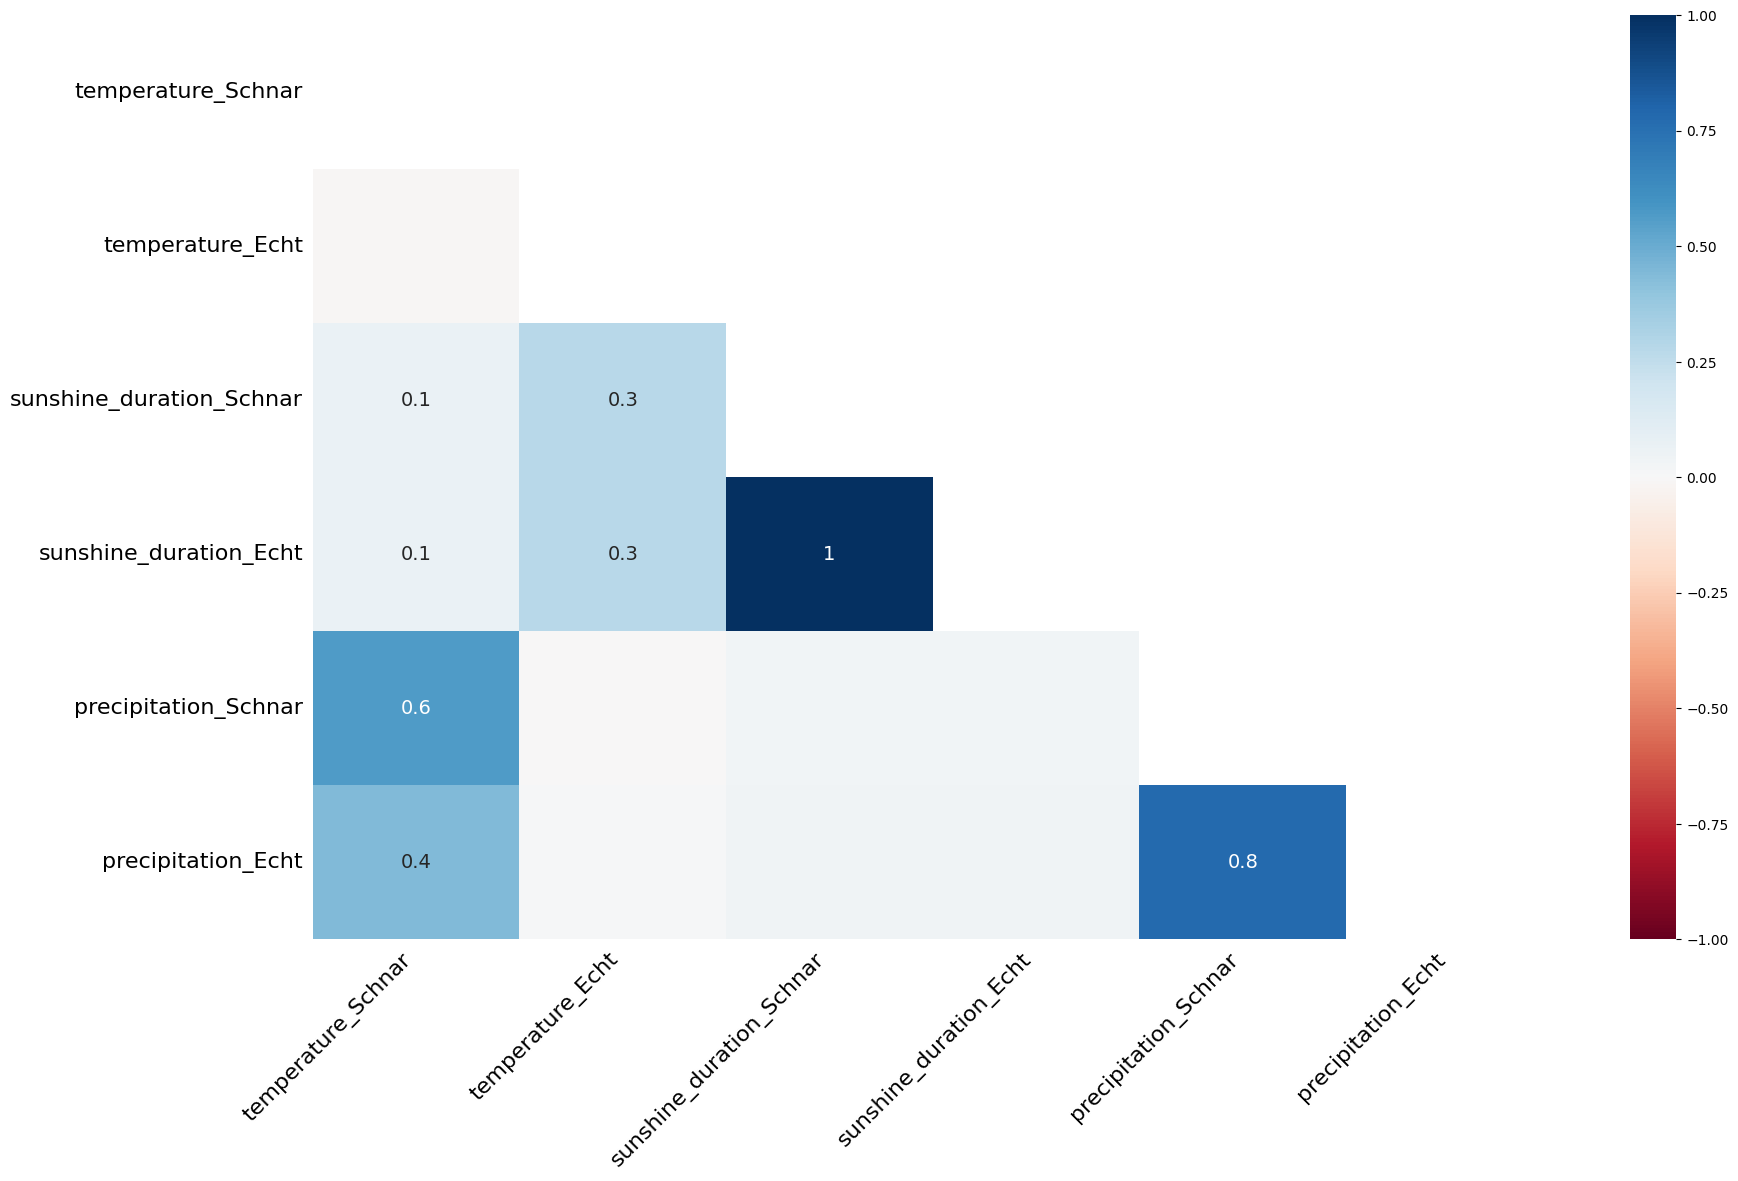

In [13]:
# Optional: Visualize missingness
msno.matrix(weather, figsize=(8, 3))
msno.heatmap(weather)
plt.show()

In [14]:
## Conduct multiple imputation using MICE

# Store original index
original_index = weather.index.copy()

# Initialize MICEData object
mice_data = MICEData(weather)

# Impute missing values
mice_data.update_all()

# Check imputed dataset
weather_imputed = mice_data.data.copy()
weather_imputed.index = original_index  # Reassign the original index
weather_imputed.head()

,temperature_Schnar,temperature_Echt,sunshine_duration_Schnar,sunshine_duration_Echt,precipitation_Schnar,precipitation_Echt,BF10,BF20,BF30,BF40,BF50,BF60
datetime,,,,,,,,,,,,
2018-01-01 00:00:00,8.9,9.2,2.0,0.0,0.1,0.0,95.0,98.0,101.0,101.0,99.0,96.0
2018-01-01 01:00:00,9.0,8.4,0.0,0.0,0.3,0.0,95.0,98.0,101.0,101.0,99.0,96.0
2018-01-01 02:00:00,8.8,7.9,0.0,0.0,0.0,0.0,95.0,98.0,101.0,101.0,99.0,96.0
2018-01-01 03:00:00,8.2,7.7,0.0,0.0,0.0,0.0,95.0,98.0,101.0,101.0,99.0,96.0
2018-01-01 04:00:00,8.2,7.3,0.0,0.0,0.0,0.0,95.0,98.0,101.0,101.0,99.0,96.0


#### 1.3.) Add holiday data

In [15]:
# Read in holiday data for Bade-Württemberg - set as binary variable
holiday_dates = []
for year in range(2016, 2024):
    with open(f"../data/holidays/feiertage_bw_{year}.json", "r") as f:
        holidays = json.load(f)
        for key in holidays.keys():
            holiday_dates.append(holidays[key]["datum"])
holiday_dates = pd.to_datetime(holiday_dates, format="%Y-%m-%d")
df_hourly["is_holiday"] = df_hourly["date"].dt.date.isin(holiday_dates.date).astype(int)

In [16]:
df_merged = pd.merge(
    df_hourly,
    weather_imputed[
        [
            "temperature_Schnar",
            "sunshine_duration_Schnar",
            "precipitation_Schnar",
            "BF10",
            "BF20",
            "BF30",
            "BF40",
            "BF50",
            "BF60",
        ]
    ],
    on="datetime",
    how="inner",
)
df_merged["T_hot"] = np.maximum(df_merged["temperature_Schnar"] - 25, 0)
df_merged["T_hot^2"] = (
    df_merged["T_hot"] ** 2
)  # Create squared term for hot temperature to consider non-linear effects
# Add a column to indicate whether the day is a working day or a weekend
df_merged["day_of_week"] = df_merged.index.dayofweek
df_merged["is_weekend"] = (df_merged["day_of_week"] >= 5).astype(int)

df_merged.tail(5)

,nodal_demand,n_nodal_datapoints_available,date,is_holiday,temperature_Schnar,sunshine_duration_Schnar,precipitation_Schnar,BF10,BF20,BF30,BF40,BF50,BF60,T_hot,T_hot^2,day_of_week,is_weekend
datetime,,,,,,,,,,,,,,,,,
2023-12-31 19:00:00,3234.205803,35.0,2023-12-31 19:00:00,0,6.3,23.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1
2023-12-31 20:00:00,2897.477640,35.0,2023-12-31 20:00:00,0,6.3,32.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1
2023-12-31 21:00:00,2588.741674,35.0,2023-12-31 21:00:00,0,5.9,36.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1
2023-12-31 22:00:00,2588.316982,35.0,2023-12-31 22:00:00,0,5.2,59.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1
2023-12-31 23:00:00,2166.669274,35.0,2023-12-31 23:00:00,0,5.1,39.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1


### 2.) Investigate Data

#### 2.1.) Yearly Level

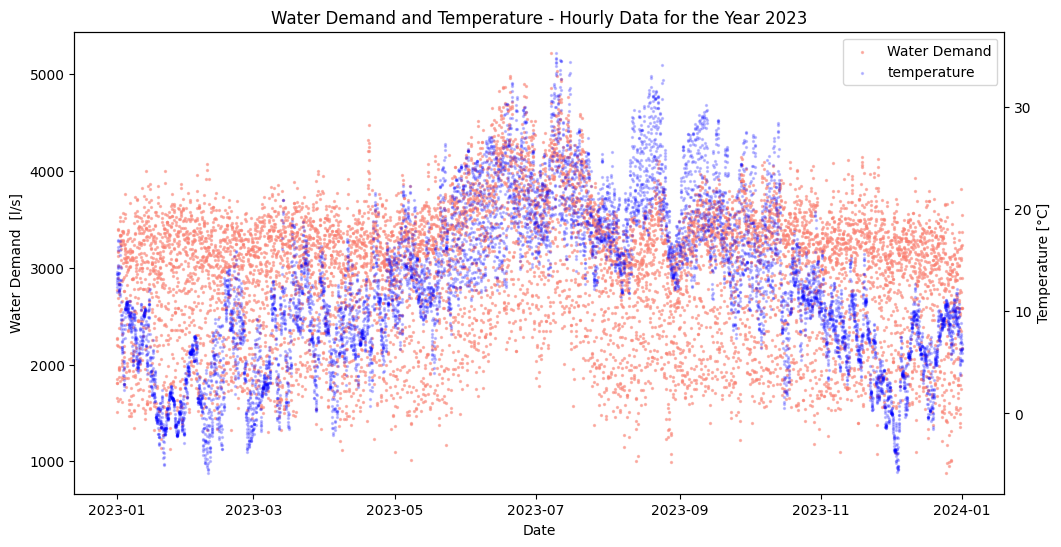

In [39]:
start_date = pd.Timestamp("2023-01-01T00")
end_date = start_date + pd.Timedelta(days=364, hours=23)
year_data = df_merged.loc[start_date:end_date]
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand  [l/s]")

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    year_data.index,
    year_data["temperature_Schnar"],
    s=2,  # Size of dots
    alpha=0.2,  # Transparency of dots
    label="temperature",
    color="blue",
)
ax2.set_ylabel("Temperature [°C]")

# Combine legends
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc="upper right")

plt.title(f"Water Demand and Temperature - Hourly Data for the Year {start_date.year}")
plt.show()

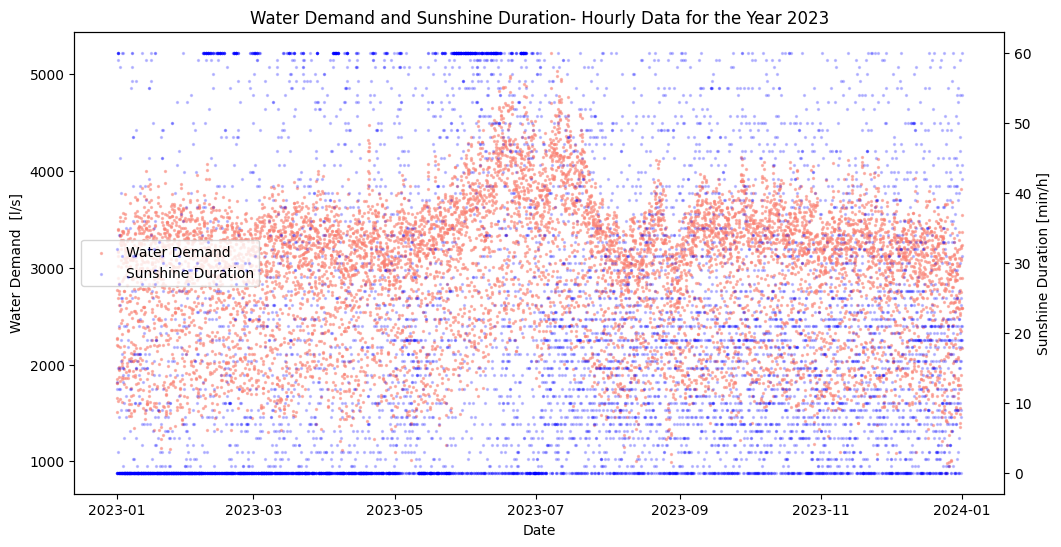

In [40]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand  [l/s]")

# Create a second y-axis for the sunshine duration
ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    year_data.index,
    year_data["sunshine_duration_Schnar"],
    s=2,  # Size of dots
    alpha=0.2,  # Transparency of dots
    label="Sunshine Duration",
    color="blue",
)
ax2.set_ylabel("Sunshine Duration [min/h]")
# Add grid
# plt.grid(visible=True, linestyle="--", alpha=0.5)

# Combine legends
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc=6)

plt.title(
    f"Water Demand and Sunshine Duration- Hourly Data for the Year {start_date.year}"
)
plt.show()

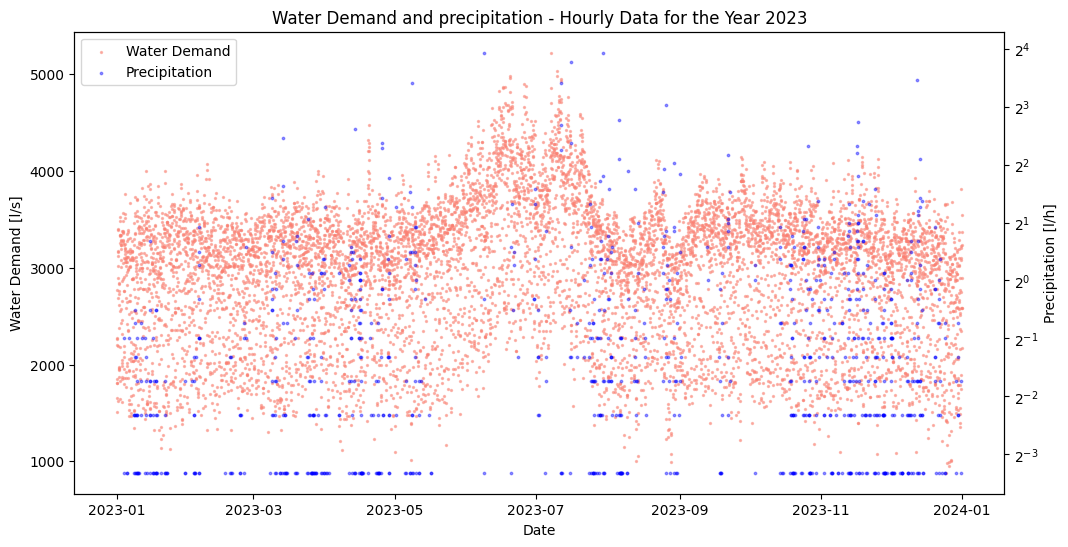

In [41]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand [l/s]")
# Create a second y-axis for the temperature
ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    year_data.index,
    year_data["precipitation_Schnar"],
    s=3,  # Size of dots
    alpha=0.4,  # Transparency of dots
    label="Precipitation",
    color="blue",
)
ax2.set_ylabel("Precipitation [l/h]")
ax2.set_yscale("log", base=2)  # Set log scale for the precipitation

# Combine legends
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc="upper left")

plt.title(
    f"Water Demand and precipitation - Hourly Data for the Year {start_date.year}"
)
plt.show()

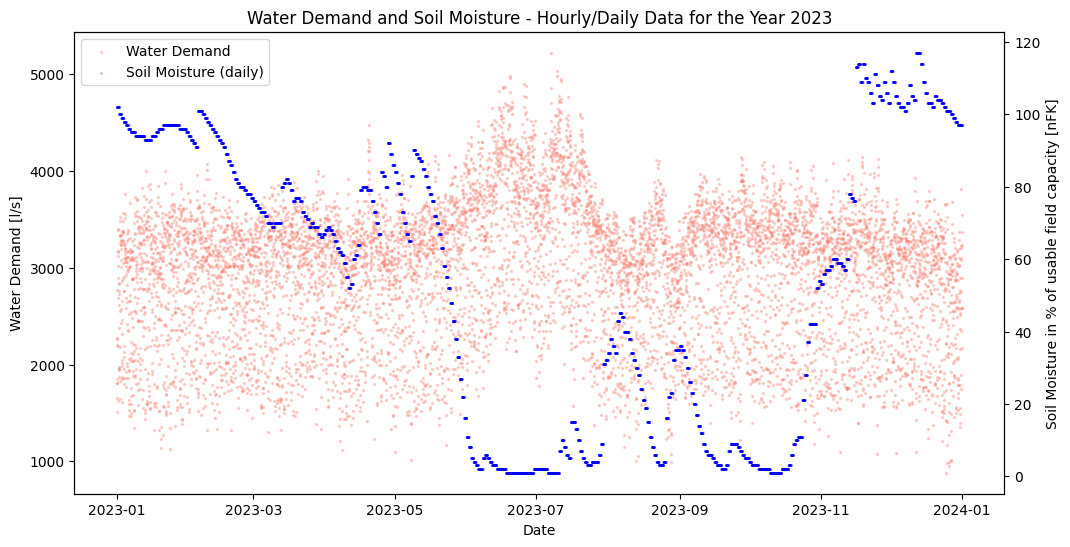

In [42]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
scatter1 = ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="Water Demand",
    color="salmon",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Water Demand [l/s]")

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
scatter2 = ax2.scatter(
    year_data.index,
    year_data["BF20"],
    s=1,  # Size of dots
    alpha=0.2,  # Transparency of dots
    label="Soil Moisture (daily)",
    color="blue",
)
ax2.set_ylabel("Soil Moisture in % of usable field capacity [nFK]")

# Combine legends
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc="upper left")

plt.title(
    f"Water Demand and Soil Moisture - Hourly/Daily Data for the Year {start_date.year}"
)
plt.show()

#### 2.2.) Weekly Level

In [43]:
start_date = "2023-06-26"
end_date = "2023-07-25"
filtered_df = df_merged[(df_merged.index >= start_date) & (df_merged.index < end_date)]

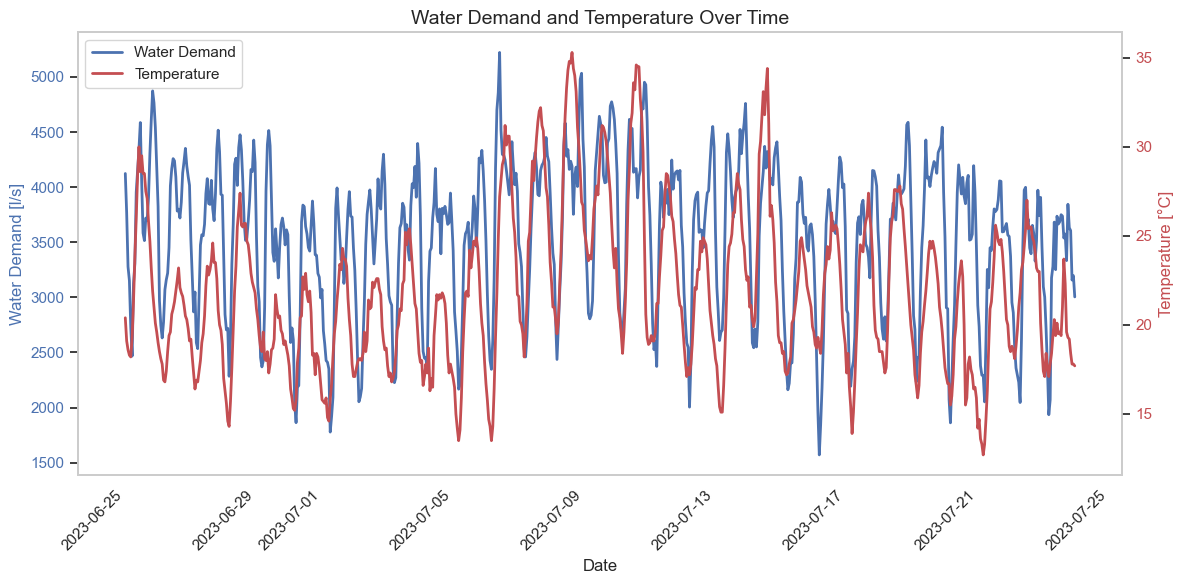

In [44]:
# Set the style
sns.set(style="whitegrid")

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the nodal_demand
ax1.plot(
    filtered_df.index,
    filtered_df["nodal_demand"],
    label="Water Demand",
    color="b",
    linewidth=2,
)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Water Demand [l/s]", color="b", fontsize=12)
ax1.tick_params(axis="x", rotation=45)
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(
    filtered_df.index,
    filtered_df["temperature_Schnar"],
    label="Temperature",
    color="r",
    linewidth=2,
)
ax2.set_ylabel("Temperature [°C]", color="r", fontsize=12)
ax2.tick_params(axis="y", labelcolor="r")

# Add grid
ax1.grid(visible=False)
ax2.grid(visible=False)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Add title
plt.title("Water Demand and Temperature Over Time", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [45]:
# Extract the hour and date from the timestamp
year_data["hour"] = year_data.index.hour
year_data["date"] = year_data.index.date


# Separate the data into working days and weekends
working_days = year_data.loc[year_data["is_weekend"] == False].copy()
weekends = year_data.loc[year_data["is_weekend"] == True].copy()
holidays = year_data.loc[year_data["is_holiday"] == True].copy()

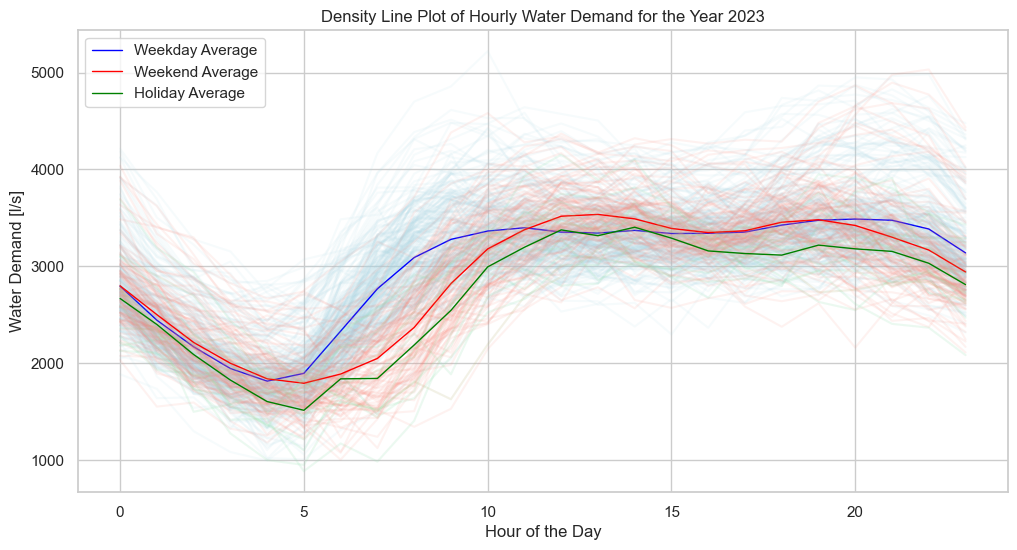

In [47]:
# 3. Pivot to have each day as a row, each hour (0..23) as a column
pivot_wd = (
    working_days.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)
pivot_we = (
    weekends.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)
pivot_ho = (
    holidays.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)

plt.figure(figsize=(12, 6))

# Plot each weekday's daily line in a faint color
for day in pivot_wd.index:
    plt.plot(pivot_wd.columns, pivot_wd.loc[day], color="lightblue", alpha=0.1)

# Plot the average weekday demand line in thicker blue
avg_wd = pivot_wd.mean(axis=0)
plt.plot(pivot_wd.columns, avg_wd, color="blue", linewidth=1, label="Weekday Average")

# Plot each weekend day's daily line in a faint color
for day in pivot_we.index:
    plt.plot(pivot_we.columns, pivot_we.loc[day], color="salmon", alpha=0.1)

# Plot the average weekend demand line in thicker red
avg_we = pivot_we.mean(axis=0)
plt.plot(pivot_we.columns, avg_we, color="red", linewidth=1, label="Weekend Average")

# Plot each holiday daily line in a faint color
for day in pivot_ho.index:
    plt.plot(pivot_ho.columns, pivot_ho.loc[day], color="lightgreen", alpha=0.1)

# Plot the average holiday demand line in thicker red
avg_ho = pivot_ho.mean(axis=0)
plt.plot(pivot_ho.columns, avg_ho, color="green", linewidth=1, label="Holiday Average")


# Final styling
plt.xlabel("Hour of the Day")
plt.ylabel("Water Demand [l/s]")
plt.title("Density Line Plot of Hourly Water Demand for the Year 2023")
plt.legend()
plt.grid(True)
plt.show()

### 3.) SARIMA model - One Day Ahead Forecast

#### 3.1.) Identifying the dependence orders of the model

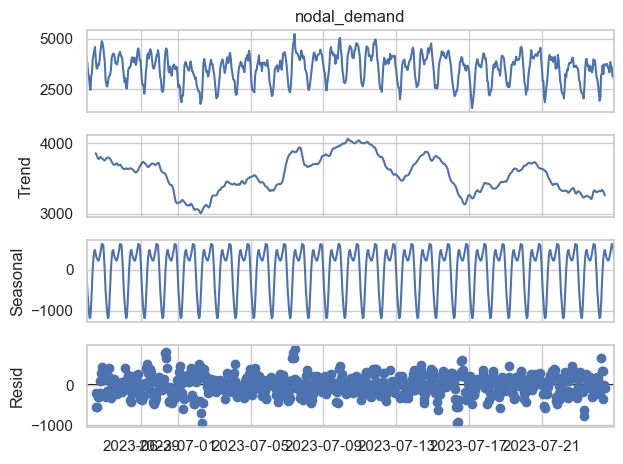

In [48]:
decomposition = seasonal_decompose(
    filtered_df["nodal_demand"], model="additive", period=24
)
decomposition.plot()
plt.show()

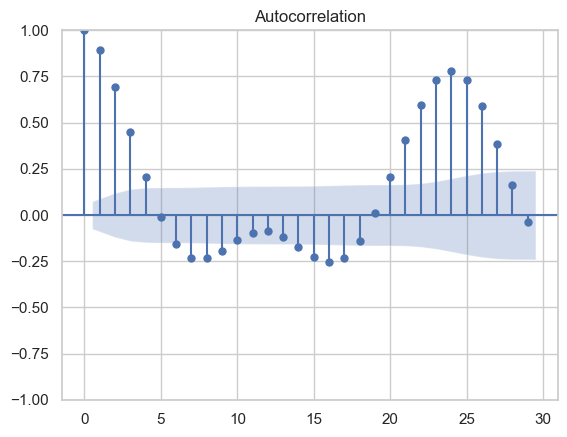

In [49]:
plot_acf(filtered_df["nodal_demand"])
plt.show()

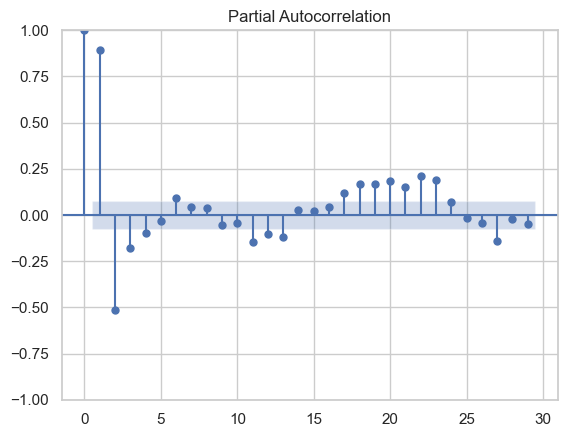

In [50]:
plot_pacf(filtered_df["nodal_demand"])
plt.show()

#### 3.2.) Fitting the Model

In [23]:
rolling_seven_day_forecast = []
for days in range(0, 7):
    train_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=days)
    train_end_date = train_start_date + pd.Timedelta(days=14) - pd.Timedelta(hours=1)
    fc = train_and_forecast_sarima(filtered_df, train_start_date, train_end_date, 24)
    rolling_seven_day_forecast.append(fc)

order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4672.94
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4681.32
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4680.98
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4684.1
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4675.28
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4661.07
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4656.31


In [24]:
forecast = np.array(rolling_seven_day_forecast).flatten()
test_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=14)
test_end_date = test_start_date + pd.Timedelta(days=7)
measured = filtered_df.loc[
    (filtered_df.index >= test_start_date) & (filtered_df.index < test_end_date),
    ["nodal_demand"],
]
error = measured["nodal_demand"] - forecast  # Calculate error

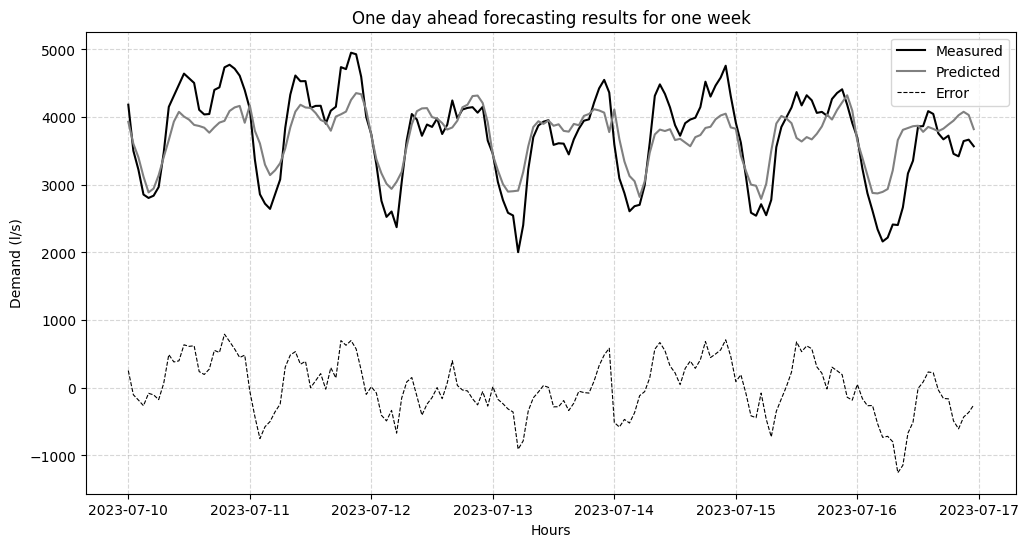

In [25]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot measured and predicted demand
plt.plot(measured.index, measured, label="Measured", color="black", linewidth=1.5)
plt.plot(measured.index, forecast, label="Predicted", color="gray", linewidth=1.5)

# Plot error
plt.plot(
    measured.index, error, label="Error", color="black", linestyle="--", linewidth=0.8
)

# Add labels, legend, and title
plt.xlabel("Date")
plt.ylabel("Water Demand [l/s]")
plt.title("One Day Ahead Forecasting Results for One Week - 07/2023")
plt.legend()

# Add grid
plt.grid(visible=True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

### 4.) SARIMAX - Weather Based
Mid-term forecast based on exogoneous variables and time-serie decomposition

In [51]:
start_date = pd.Timestamp("2021-01-01T00")
end_date = pd.Timestamp("2023-12-31T23")
three_year_data = df_merged.loc[start_date:end_date].copy()
three_year_data.describe()

,nodal_demand,n_nodal_datapoints_available,date,is_holiday,temperature_Schnar,sunshine_duration_Schnar,precipitation_Schnar,BF10,BF20,BF30,BF40,BF50,BF60,T_hot,T_hot^2,day_of_week,is_weekend
count,26280.000000,26280.000000,26280,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,3021.649505,33.139916,2022-07-02 11:30:00,0.035616,11.679654,19.177778,0.073311,56.749772,52.306849,63.152511,76.821005,84.631050,88.643836,0.148048,0.691131,3.005479,0.286758
min,882.301577,32.000000,2021-01-01 00:00:00,0.000000,-11.300000,0.000000,0.000000,0.000000,0.000000,2.000000,30.000000,55.000000,70.000000,0.000000,0.000000,0.000000,0.000000
25%,2538.973624,32.000000,2021-10-01 17:45:00,0.000000,5.500000,0.000000,0.000000,23.000000,14.000000,39.000000,64.000000,76.000000,81.000000,0.000000,0.000000,1.000000,0.000000
50%,3148.147079,33.000000,2022-07-02 11:30:00,0.000000,11.300000,10.000000,0.000000,63.000000,57.000000,69.000000,79.000000,85.000000,87.000000,0.000000,0.000000,3.000000,0.000000
75%,3492.109856,33.000000,2023-04-02 05:15:00,0.000000,17.500000,35.000000,0.000000,91.000000,85.000000,91.000000,95.000000,95.000000,96.000000,0.000000,0.000000,5.000000,1.000000
max,5286.708269,35.000000,2023-12-31 23:00:00,1.000000,36.300000,60.000000,41.600000,111.000000,117.000000,121.000000,123.000000,123.000000,120.000000,11.300000,127.690000,6.000000,1.000000
std,672.256369,1.101054,NaN,0.185335,7.999181,21.800743,0.521591,36.551398,37.425814,31.541478,21.156334,13.047508,8.795511,0.818070,5.464582,2.000487,0.452256


In [ ]:
# # Generate Fourier terms for weekly cycle
# K = 3  # Number of sine/cosine pairs (tune as needed)
# fourier_df = fourier_series(
#     three_year_data.index, K=K, period=168
# )  # period = 168 since weekly cycle
# three_year_data = three_year_data.join(fourier_df, on="datetime", how="left")
# three_year_data.head(5)

In [52]:
# create interaction terms
three_year_data["dry_soil"] = np.minimum(0, three_year_data["BF20"] - 50) * -1

In [53]:
#  Prepare the data
endog = three_year_data["nodal_demand"]
exog = three_year_data[
    [
        "T_hot",
        "T_hot^2",
        "is_weekend",
        "is_holiday",
        # "precipitation_Schnar",
        # "T_hot*sunshine_duration_Schnar",
        # "T_hot*precipitation_Schnar",
        "dry_soil",
        # "sin_168_1",
        # "cos_168_1",
        # "sin_168_2",
        # "cos_168_2",
        # "sin_168_3",
        # "cos_168_3",
    ]
]

# Split the data into training and testing sets (optional)
train_endog = endog[: 2 * 365 * 24]
test_endog = endog[2 * 365 * 24 + 1 :]
train_exog = exog[: 2 * 365 * 24]
test_exog = exog[2 * 365 * 24 + 1 :]

#### 4.1.) Determine model parameters

In [54]:
# Fit the SARIMAX model
model = SARIMAX(
    train_endog, exog=train_exog, order=(1, 0, 3), seasonal_order=(0, 1, 1, 24)
)
results = model.fit()
# Print the summary of the model
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         nodal_demand   No. Observations:                17520
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 24)   Log Likelihood             -117419.376
Date:                              Sun, 02 Feb 2025   AIC                         234860.751
Time:                                      18:07:59   BIC                         234946.218
Sample:                                  01-01-2021   HQIC                        234888.896
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T_hot         35.4467      9.870      3.591      0.000      16.102      54.791
T_hot^2       -4.35

In [55]:
# Make predictions one year ahead
predictions = results.get_forecast(steps=364 * 24 + 23, exog=test_exog)
predicted_mean = predictions.predicted_mean

In [56]:
predicted_mean = pd.DataFrame(predicted_mean).set_index(test_endog.index)

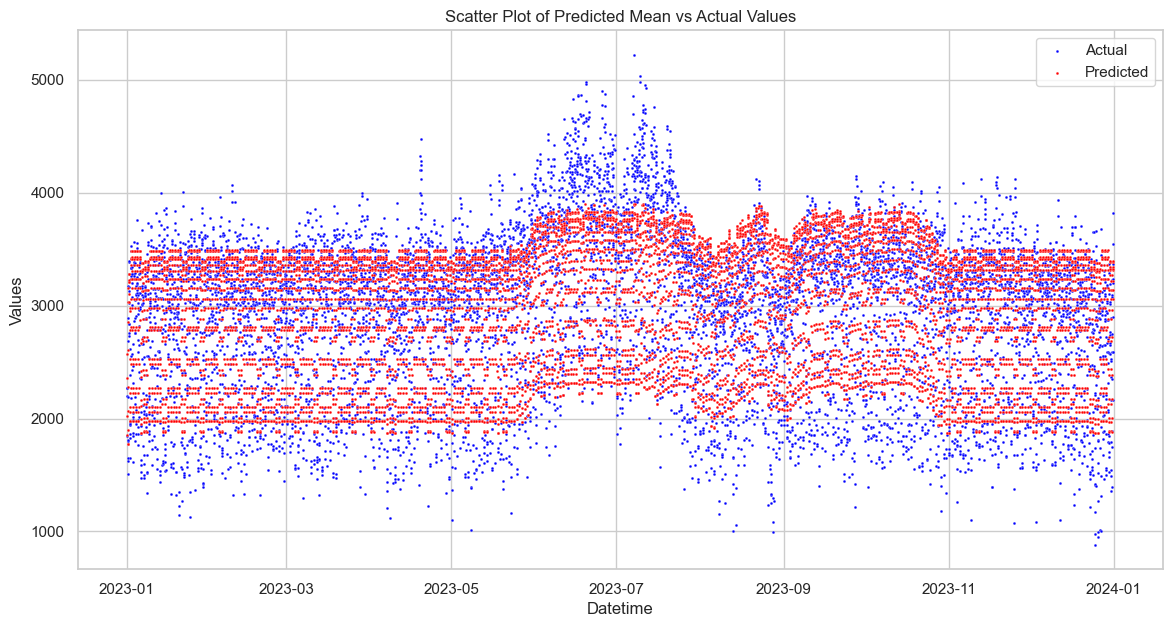

In [ ]:
plt.figure(figsize=(14, 7))
sns.scatterplot(
    x="datetime",
    y="nodal_demand",
    data=pd.DataFrame(test_endog),
    label="Actual",
    color="blue",
    s=4,
)
sns.scatterplot(
    x="datetime",
    y="predicted_mean",
    data=pd.DataFrame(predicted_mean),
    label="Predicted",
    color="red",
    s=4,
)
plt.xlabel("Date")
plt.ylabel("Water Demand [l/s]")
plt.title("Scatter Plot of Predicted Mean vs Actual Values")
plt.legend()
plt.show()

### 5.) Prophet

In [47]:
prophet_df = df_merged[["date", "nodal_demand"]].rename(
    columns={"date": "ds", "nodal_demand": "y"}
)
prophet_df.tail(5)

,ds,y
datetime,,
2023-12-31 19:00:00,2023-12-31 19:00:00,3234.205803
2023-12-31 20:00:00,2023-12-31 20:00:00,2897.477640
2023-12-31 21:00:00,2023-12-31 21:00:00,2588.741674
2023-12-31 22:00:00,2023-12-31 22:00:00,2588.316982
2023-12-31 23:00:00,2023-12-31 23:00:00,2166.669274


In [99]:
prophet_df[: -365 * 24]

,ds,y
datetime,,
2018-01-01 00:00:00,2018-01-01 00:00:00,2481.356308
2018-01-01 01:00:00,2018-01-01 01:00:00,2414.395364
2018-01-01 02:00:00,2018-01-01 02:00:00,2156.941040
2018-01-01 03:00:00,2018-01-01 03:00:00,2046.451207


In [40]:
# Python
m = Prophet(
    changepoint_prior_scale=0.01,
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=True,
)
m.fit(prophet_df[: -365 * 24])

19:11:25 - cmdstanpy - INFO - Chain [1] start processing
19:12:08 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
future = m.make_future_dataframe(periods=365 * 24, freq="H")

In [42]:
# Prognose erstellen
forecast = m.predict(future)

In [ ]:
prophet_df["yhat"] = forecast["yhat"].values

In [64]:
# Select 6 weeks of data
week_indexes = [1, 12, 25, 30, 40, 50]
weeks = [prophet_df[-365 * 24 :].iloc[i * 168 : (i + 1) * 168] for i in week_indexes]

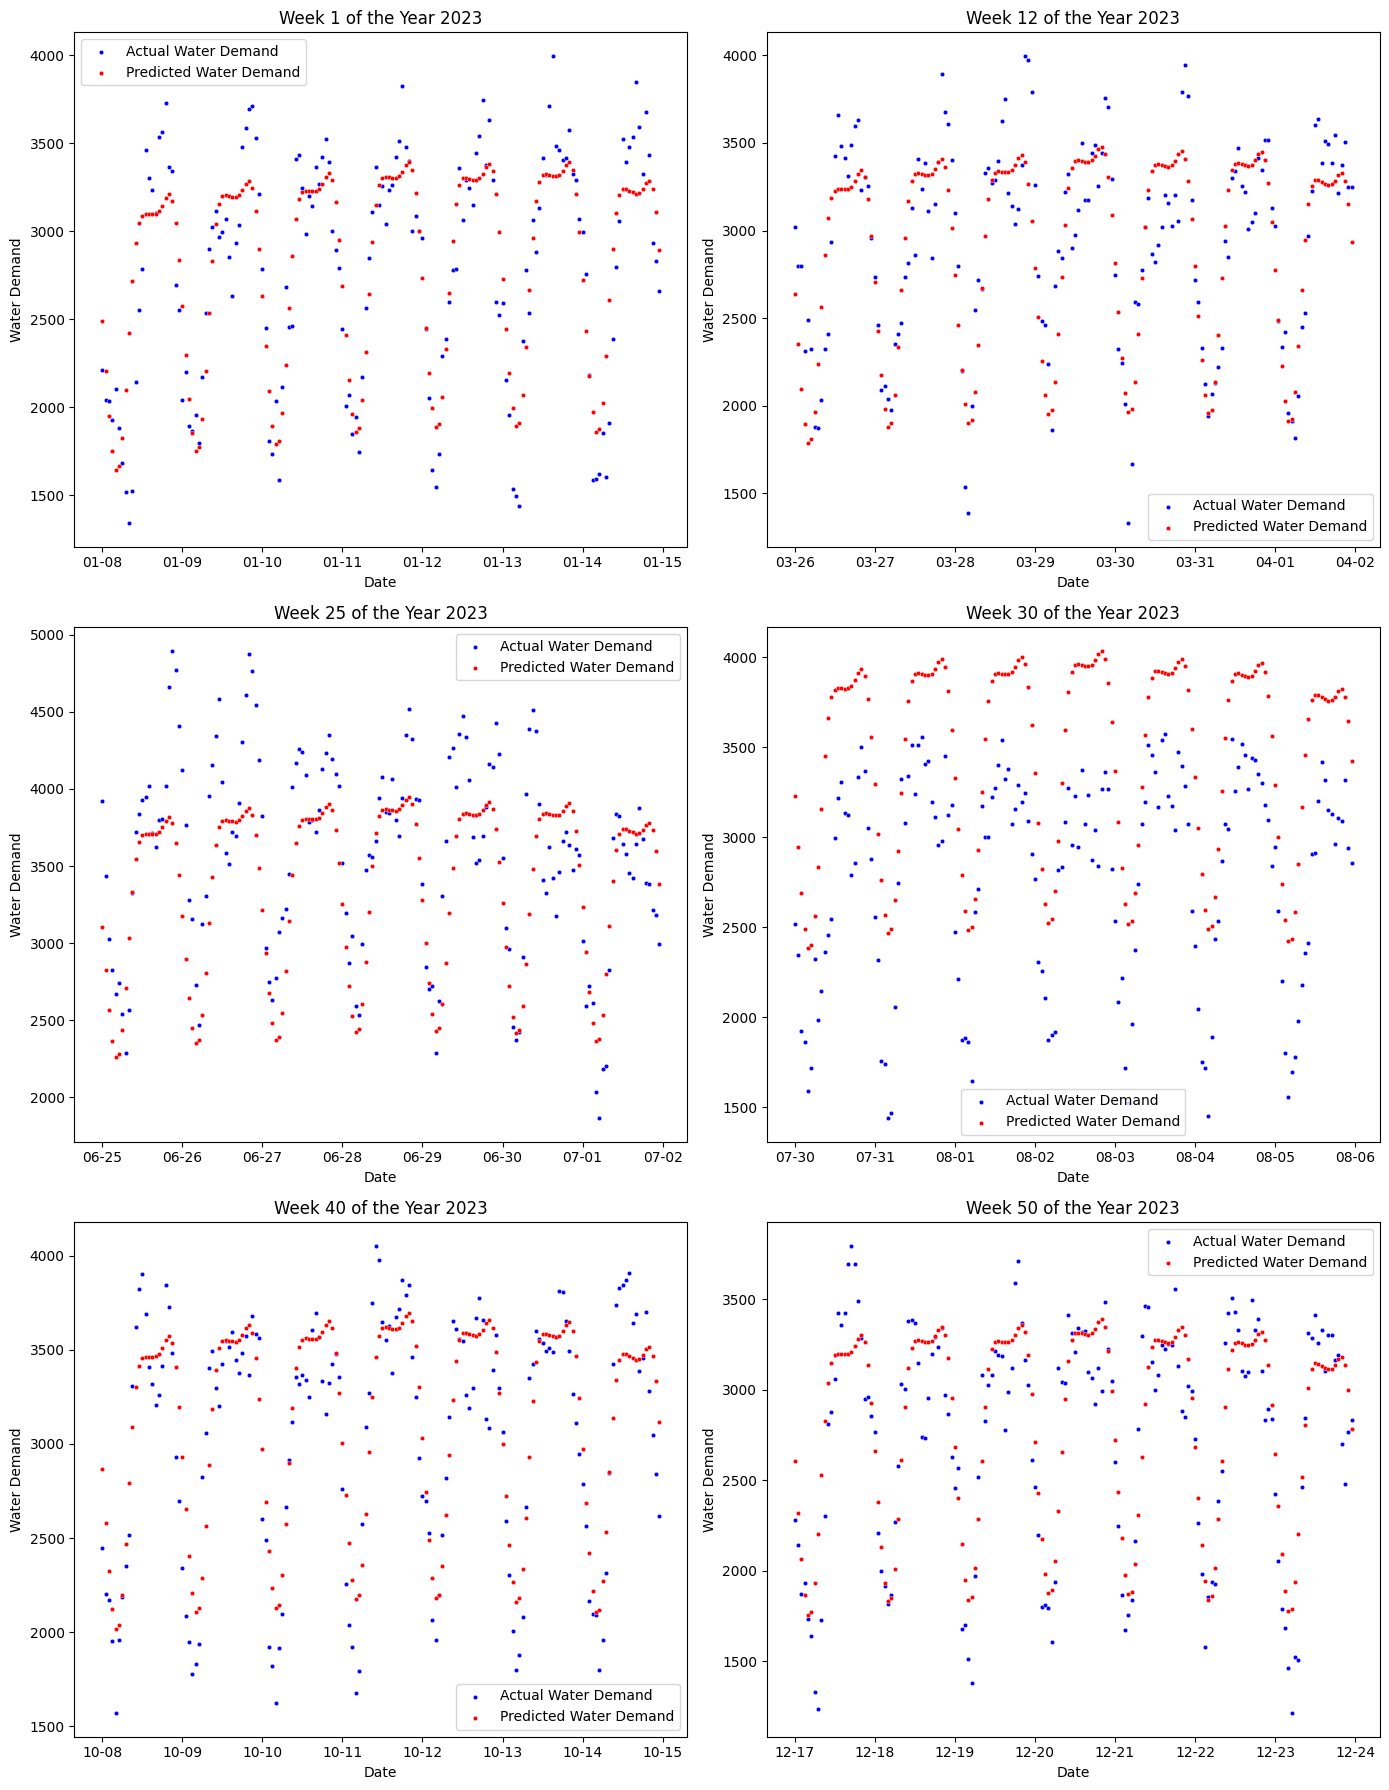

In [70]:
# Create the plots
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

for i, week in enumerate(weeks):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(
        x=week.index,
        y=week["y"],
        label="Actual Water Demand",
        color="blue",
        s=10,  # Size of dots
        ax=ax,
    )
    sns.scatterplot(
        x=week.index,
        y=week["yhat"],
        label="Predicted Water Demand",
        color="red",
        s=10,  # Size of dots
        ax=ax,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Water Demand")
    ax.set_title(f"Week {week_indexes[i]} of the Year 2023")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))  # Format x-axis ticks

plt.tight_layout()
plt.show()

In [ ]:
# Python
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial="730 days", period="365 days", horizon="365 days")

  0%|          | 0/3 [00:00<?, ?it/s]

19:24:36 - cmdstanpy - INFO - Chain [1] start processing
19:24:43 - cmdstanpy - INFO - Chain [1] done processing
19:24:48 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
a = 2

In [ ]:
help(pd.DateTime)

In [ ]:
# Python
df_cv.head()

In [ ]:
# Python
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
# Modell instanziieren
model = Prophet(
    growth="linear",  # Trend (linear oder logistic)
    weekly_seasonality=True,  # wöchentliche Saisonalität
    yearly_seasonality=True,  # jährliche Saisonalität
    daily_seasonality=False,  # hier beispielhaft ausgeschaltet
)

# Fit
model.fit(df)

# Zukunftsdaten (Forecast-Horizont) erzeugen
future = model.make_future_dataframe(periods=60)  # z. B. 60 Tage in die Zukunft

# Prognose erstellen
forecast = model.predict(future)

# Optional: Prognosen plotten
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)